# LDA for fake news classification

In [541]:
import pandas as pd
data = pd.read_csv('WELFake_Dataset.csv')
#print(data.shape)
subset = data[0:1500] #currently experimenting on subset, 
subset.head()


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [542]:
data.shape

(72134, 4)

In [543]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import numpy as np
np.random.seed(42)
import pandas as pd
from gensim.models import ldamodel
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer;



In [544]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [545]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('words')

# Define English stopwords from NLTK
nltk_stopwords = set(stopwords.words('english'))

# Define your custom stopwords
custom_stopwords = set(['one', 'bensasse', 'said', 'like','bowl', 'right', 'new', 'would', 'told', 'get', 'old', 'going', 'seems', 'lynching', 'also', 'way', 'call','as','per','one','two','could','got','ing'])

# Combine NLTK stopwords with custom stopwords
all_stopwords = nltk_stopwords.union(custom_stopwords)

# Get a set of common English words
english_words = set(words.words())

# Create a WordNetLemmatizer instance
lemmatizer = WordNetLemmatizer()

def preprocess(corpus):
    cleaned_corpus = []
    
    for text in corpus:
        # Lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove links
        text = re.sub(r'https?://[^\s\n\r]+', '', text)
        # Remove words associated with #
        text = re.sub(r'#\S+', ' ', text)
        # Remove non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        # Tokenize and remove stopwords
        words = nltk.word_tokenize(text)
        words = [word for word in words if word not in all_stopwords and len(word) > 3 and word in english_words]  # Filter out single letters and meaningless words
        # Lemmatize words
        words = [lemmatizer.lemmatize(word) for word in words]
        # Remove words containing numbers
        words = [word for word in words if not re.search(r'\d', word)]
        cleaned_corpus.append(words)
    
    return cleaned_corpus




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package words is already up-to-date!


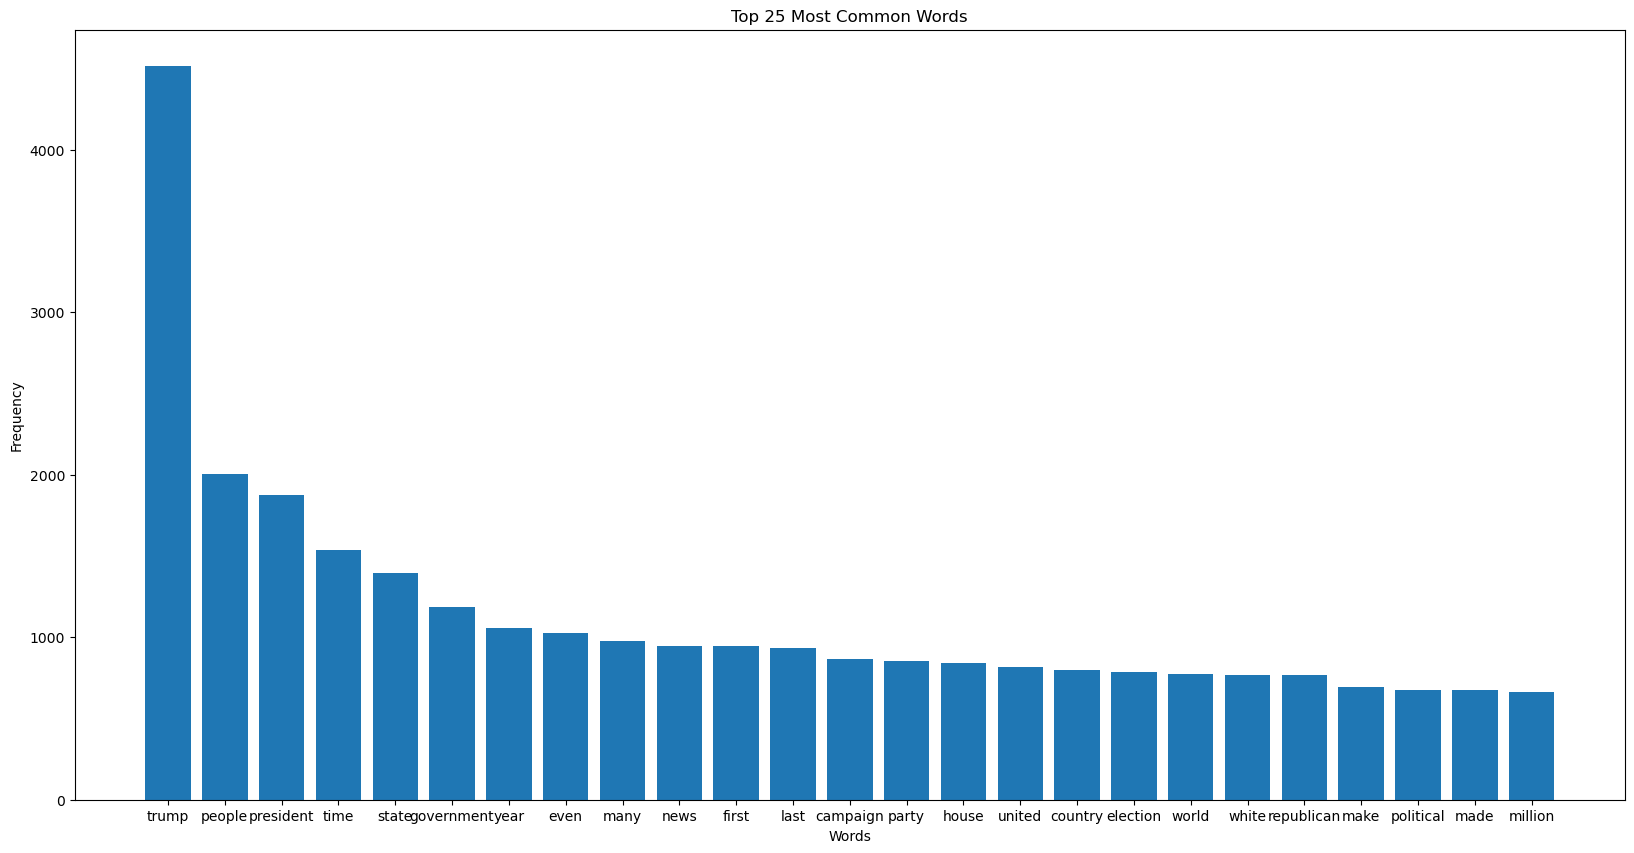

In [546]:
import matplotlib.pyplot as plt
from collections import Counter
new_data = subset['text'].apply(str)

cleaned_corpus = preprocess(new_data)  

# Flatten the list of processed words
all_words = [word for sublist in cleaned_corpus for word in sublist]

# Count word occurrences
word_counts = Counter(all_words)

# Select the top N words
top_words = word_counts.most_common(25)

# Plot the results
plt.figure(figsize=(20, 10))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 Most Common Words')
plt.show()


In [547]:
# converting data into list
new_data = subset['text'].apply(str)  # remember im using subset here.
data_of_words = list(preprocess(new_data))
print(data_of_words[0][:10])  # grabbing the first 10 words


['comment', 'hanging', 'white', 'people', 'radio', 'show', 'night', 'turn', 'tide', 'kill']


In [566]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from itertools import islice

# Explicitly define data_words
data_words = list(preprocess(subset['text'].apply(str)))  
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100)  # higher threshold, fewer phrases
trigram = Phrases(bigram[data_words], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
# Assuming data_words is your preprocessed data
bigram_data = [bigram_mod[doc] for doc in data_words]
trigram_data = [trigram_mod[bigram_mod[doc]] for doc in data_words]

def m_bigram(texts):
    return (bigram_mod[doc] for doc in texts)

def m_trigram(texts):
    return (trigram_mod[bigram_mod[doc]] for doc in texts)

# Apply bigram and trigram models directly to data_of_words
new_bigram_trigram = m_trigram(m_bigram(data_words))

# Print the first 10 elements of the first document after applying bigram and trigram models
print(list(islice(new_bigram_trigram, 1))[0][:10])


['comment', 'hanging', 'white', 'people', 'radio', 'show', 'night', 'turn', 'tide', 'kill']


In [549]:
# creating a dictionary
id2word = corpora.Dictionary(data_words)

In [550]:
#creating a corpus
#in this cell what happens is creating a bag of words which will contain a list of unique words and their frequency in the corpus.
corpus = []
for text in data_words:
    new_text = id2word.doc2bow(text)
    corpus.append(new_text)
print(corpus[0][0:10])
#the results printed below in the form of tuples will represent (x,y) where x is the index of the word in the dictionary and y is the frequency of the word.

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 2), (7, 1), (8, 1), (9, 10)]


In [551]:
#Building the lda model.

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           update_every=1,#updates topic model after each iteration
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           iterations=30,
                                           per_word_topics=True)

print(pd.DataFrame(lda_model.print_topics()))
 #it will show a list of keywords plus the weight each word has on the topic, which will help me determine what each topic could be based on weights of the words.

   0                                                  1
0  0  0.015*"government" + 0.011*"state" + 0.011*"un...
1  1  0.019*"police" + 0.015*"year" + 0.010*"people"...
2  2  0.018*"people" + 0.010*"even" + 0.010*"time" +...
3  3  0.070*"trump" + 0.025*"president" + 0.017*"cam...
4  4  0.018*"medium" + 0.018*"news" + 0.013*"video" ...


In [552]:
def lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 25);
        word_dict['Topic ' + '{:2d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [553]:
num_topics=5

In [554]:
lda_topics(lda_model, num_topics)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,government,police,people,trump,medium
1,state,year,even,president,news
2,united,people,time,campaign,video
3,president,water,think,election,twitter
4,military,city,many,republican,show
5,security,according,make,state,image
6,million,found,first,former,time
7,foreign,local,love,house,story
8,year,family,much,white,featured
9,country,many,world,presidential,black


In [555]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_30278/3614166587.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/Users/amreshsenathirajah/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


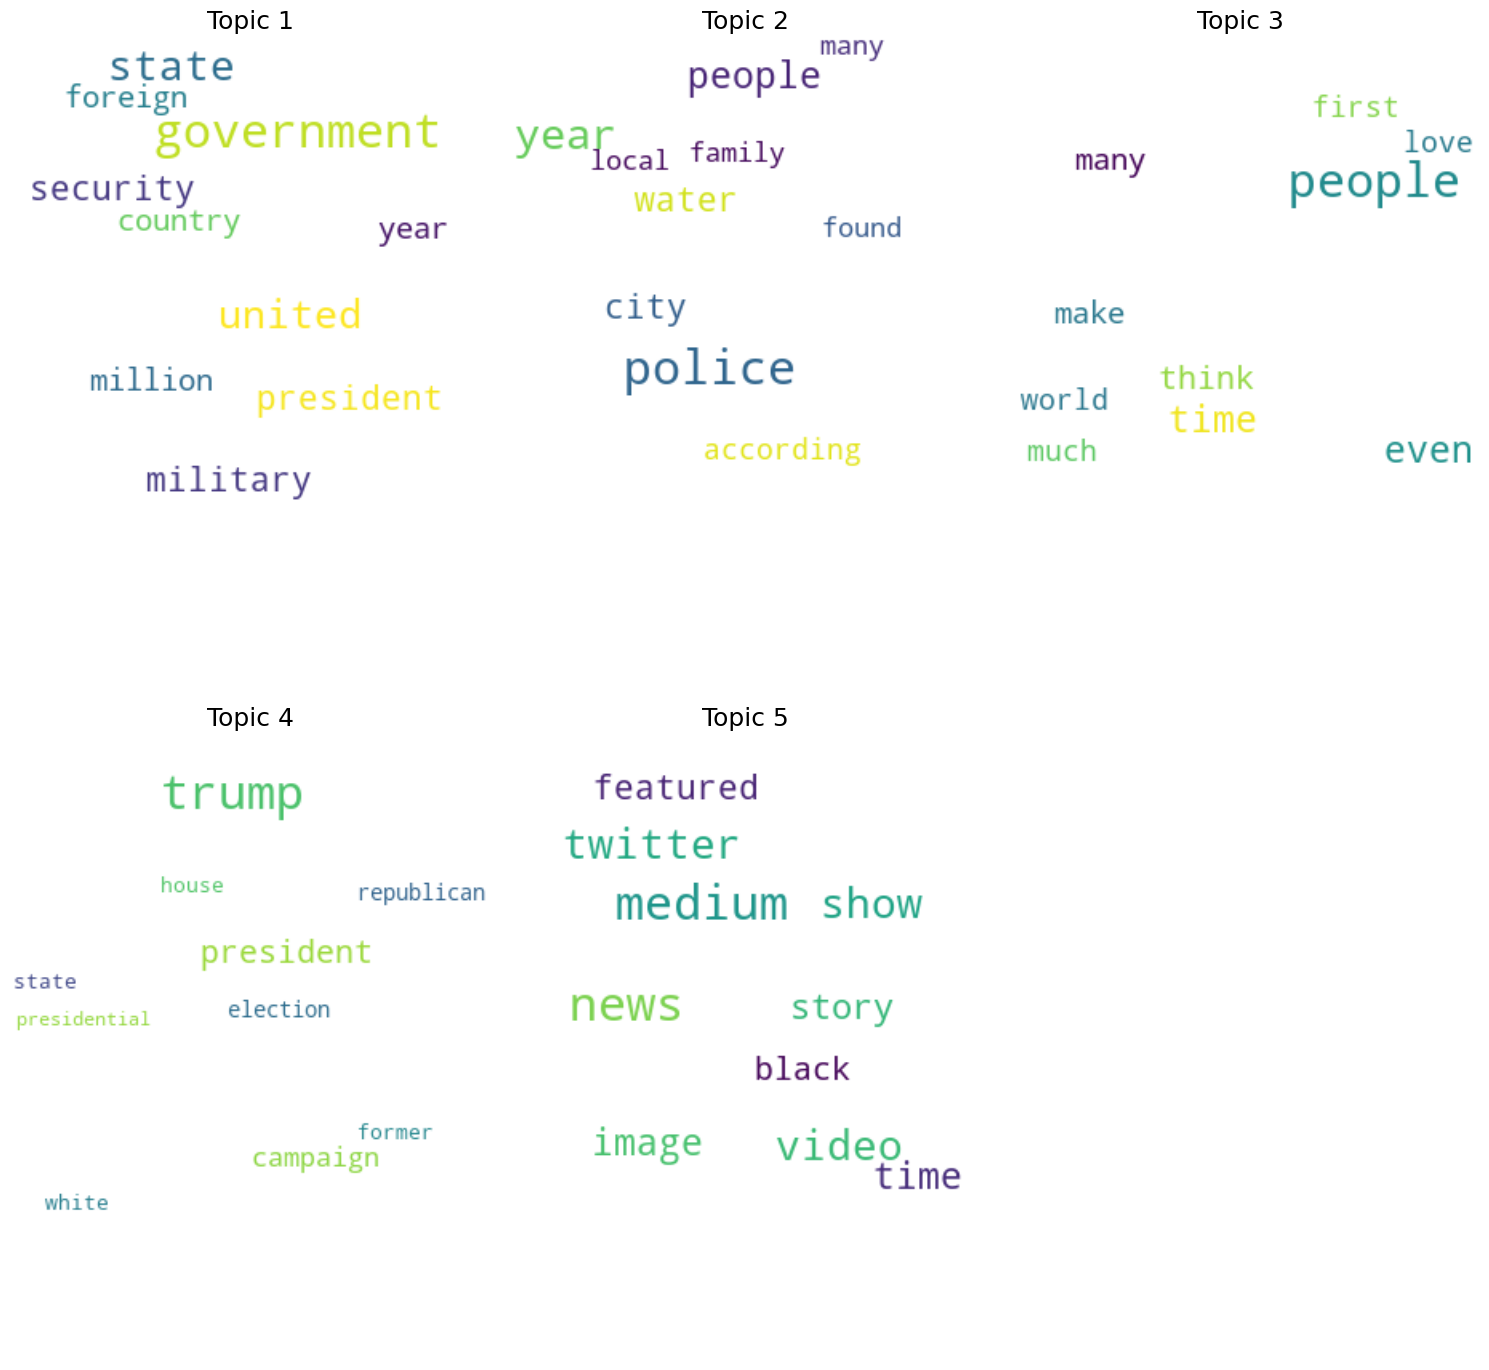

In [556]:

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.cm as cm

# Choose a colormap 
cmap = cm.get_cmap('viridis')

# Create a WordCloud 
wordcloud = WordCloud(
    background_color='white',
    width=300,
    height=300,
    max_words=300,
    colormap=cmap,
    prefer_horizontal=1.0
)

topics = lda_model.show_topics(formatted=False)

# Calculate the number of rows and columns for subplots
num_topics = len(topics)
num_cols = 3  # You can adjust the number of columns as needed
num_rows = (num_topics + num_cols - 1) // num_cols

# Plot the WordCloud per topic
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15), facecolor='white')

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        # Extract words and their weights from the current topic
        topic_words = dict(topics[i][1])
        
        # Generate WordCloud for the current topic
        wordcloud.generate_from_frequencies(topic_words, max_font_size=30)
        
        # Plot WordCloud
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f'Topic {i + 1}', fontsize=18)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
#wordcloud may not display more than a certain amount of topics at a time.

In [557]:


def lda_topics_with_contributions(ldamodel, corpus, num_topics, texts):
    topic_dict = {'Dominant_Topic': [], 'Perc_Contribution': [], 'Topic_Keywords': []}

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_dict['Dominant_Topic'].append(int(topic_num))
                topic_dict['Perc_Contribution'].append(round(prop_topic, 4))
                topic_dict['Topic_Keywords'].append(topic_keywords)
            else:
                break

    # Add original text to the end of the output
    topic_df = pd.DataFrame(topic_dict)
    contents = pd.Series(new_data)
    result_df = pd.concat([topic_df, contents], axis=1)
    result_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return result_df



In [558]:

num_topics = lda_model.num_topics
df_topics_with_contributions = lda_topics_with_contributions(lda_model, corpus, num_topics, data)

# Display the DataFrame with topics and their percentage contributions for each document
print(df_topics_with_contributions)



      Dominant_Topic  Perc_Contribution  \
0                  4             0.4660   
1                  2             0.3338   
2                  3             0.4615   
3                  2             0.4372   
4                  0             0.5882   
...              ...                ...   
1495               0             0.4608   
1496               2             0.4386   
1497               2             0.4340   
1498               0             0.4464   
1499               3             0.6645   

                                         Topic_Keywords  \
0     medium, news, video, twitter, show, image, tim...   
1     people, even, time, think, many, make, first, ...   
2     trump, president, campaign, election, republic...   
3     people, even, time, think, many, make, first, ...   
4     government, state, united, president, military...   
...                                                 ...   
1495  government, state, united, president, military...   
1496  peopl

In [535]:
!pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds = "mmds" , R = 20)
#the larger a bubble is the more predominant that topic is.
visual

/Users/amreshsenathirajah/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.270464 -0.008642       1        1  35.869385
4      0.106077  0.193420       2        1  27.942705
2     -0.221052 -0.141711       3        1  14.081458
3     -0.191433  0.173055       4        1  11.156777
1      0.035944 -0.216121       5        1  10.949675, topic_info=          Term        Freq       Total Category  logprob  loglift
806      trump  687.000000  687.000000  Default  20.0000  20.0000
378  president  270.000000  270.000000  Default  19.0000  19.0000
304      house  123.000000  123.000000  Default  18.0000  18.0000
89      police   78.000000   78.000000  Default  17.0000  17.0000
621       city   70.000000   70.000000  Default  16.0000  16.0000
..         ...         ...         ...      ...      ...      ...
203       care   19.278864   44.789387   Topic5  -5.5252   1.3689
83      people   32.999826  242.697644   Topic5  -4.9877   0.2165
877      three   23.309646   87.695995   Topic5  -5.3354   0.8869
64        many   19.239016  154.419568   Topic5  -5.5273   0.1291
134       time   16.915875  191.491150   Topic5  -5.6560  -0.2147

[220 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
6556      4  0.981700       aborigine
174       1  0.991171  administration
612       1  0.185192          always
612       3  0.582031          always
612       5  0.238104          always
...     ...       ...             ...
467       5  0.319638            year
1379      1  0.438474            york
1379      2  0.146158            york
1379      4  0.036539            york
1379      5  0.383664            york

[343 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

In [567]:
def calculate_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = calculate_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=1, limit=6, step=1)


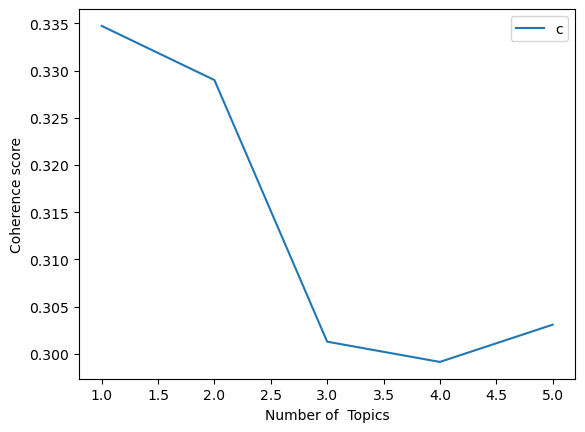

In [568]:
# Show graph
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of  Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [569]:
for a, cv in zip(x, coherence_values):
    print("Num Topics =", a, " has Coherence Value of", round(cv, 4))


Num Topics = 1  has Coherence Value of 0.3347
Num Topics = 2  has Coherence Value of 0.329
Num Topics = 3  has Coherence Value of 0.3013
Num Topics = 4  has Coherence Value of 0.2991
Num Topics = 5  has Coherence Value of 0.3031


In [570]:
# Calculating Perplexity
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity)



Perplexity:  -8.283306958123855


In [573]:
optimal_model = model_list[1]
modelTopics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.011*"trump" + 0.005*"president" + 0.005*"time" + 0.005*"state" + 0.004*"people" + 0.004*"year" + 0.004*"government" + 0.003*"party" + 0.003*"even" + 0.003*"house"'),
 (1,
  '0.018*"trump" + 0.008*"people" + 0.007*"president" + 0.005*"time" + 0.005*"state" + 0.004*"government" + 0.004*"last" + 0.004*"many" + 0.003*"news" + 0.003*"first"')]